In [1]:
%load_ext autoreload

# 引入必要的库

In [2]:
%autoreload
import sys,os
import numpy as np
import matplotlib.pyplot as plt
from tianmoucv.isp import fourdirection2xy
from tianmoucv.isp import poisson_blend
import torch
from tianmoucv.data import TianmoucDataReader
import torch.nn.functional as F
import cv2

train='/data/lyh/tianmoucData/tianmoucReconDataset/train/'
dirlist = os.listdir(train)
traindata = [train + e for e in dirlist]

val='/data/lyh/tianmoucData/tianmoucReconDataset/test/'
vallist = os.listdir(val)
valdata = [val + e for e in vallist]
key_list = []

print('---------------------------------------------------')
for sampleset in traindata:
    print('---->',sampleset,'有：',len(os.listdir(sampleset)),'个样本')
    for e in os.listdir(sampleset):
        print(e)
        key_list.append(e)
print('---------------------------------------------------')
for sampleset in valdata:
    print('---->',sampleset,'有：',len(os.listdir(sampleset)),'个样本')
    for e in os.listdir(sampleset):
        print(e)
        key_list.append(e)
        


import TianmouCV 0.1, via Y. Lin, T. Wang  pre release version
---------------------------------------------------
----> /data/lyh/tianmoucData/tianmoucReconDataset/train/extreme 有： 41 个样本
train_tunnel4_hdr_ae
hdr_people5
hdr_traffic34
train_hdr_human
hdr_traffic26
hdr_traffic35
hdr_people11
shake5
train_exam_flicker3
hdr_people14
hdr_traffic28
shake1
hdr_traffic20
hdr_people3
indoor_crazy_shake
shake4
hdr_people15
underbridge_hdr_1
train_driving2
shake2
hdr_traffic23
train_tunnel1_hdr_blur
underbridge_hdr_4
hdr_traffic29
train_exam_flicker2
hdr_people2
hdr_traffic18
hdr_traffic22
hdr_people7
hdr_people6
hdr_people9
train_tunnel3_hdr_ae
hdr_traffic30
hdr_traffic25
hdr_traffic21
hdr_traffic19
train_exam_flicker1
train_exam_fan_QRcode_1
underbridge_hdr_2
train_tunnel6_hdr_ae
train_tunnel5_hdr_ae
----> /data/lyh/tianmoucData/tianmoucReconDataset/train/normal 有： 74 个样本
train_running_man_2
traffic9
train_running_man_3
outdoor_cross_12
outdoor_bridge_1
outdoor_cross_1
train_indoor_dog4
train

# 读取单目数据

- 设置N：一个sampple中有连续几帧，默认N=1, 输出1帧RGB with M AOP
- 设置Match Key，否则会读出所有数据
- camera_idx默认为0，表示识别单目数据

train_tunnel4_hdr_ae@data/lyh/tianmoucData/tianmoucReconDataset/train/extreme origin length: 98
train_tunnel4_hdr_ae ..., --- containing [RGB,NxTSD] sample: 98  packs
tianmoucData_multiple.py TODO：add overlap parameter


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


一次性读出N: 3 个RGB帧以及与其同步的AOP


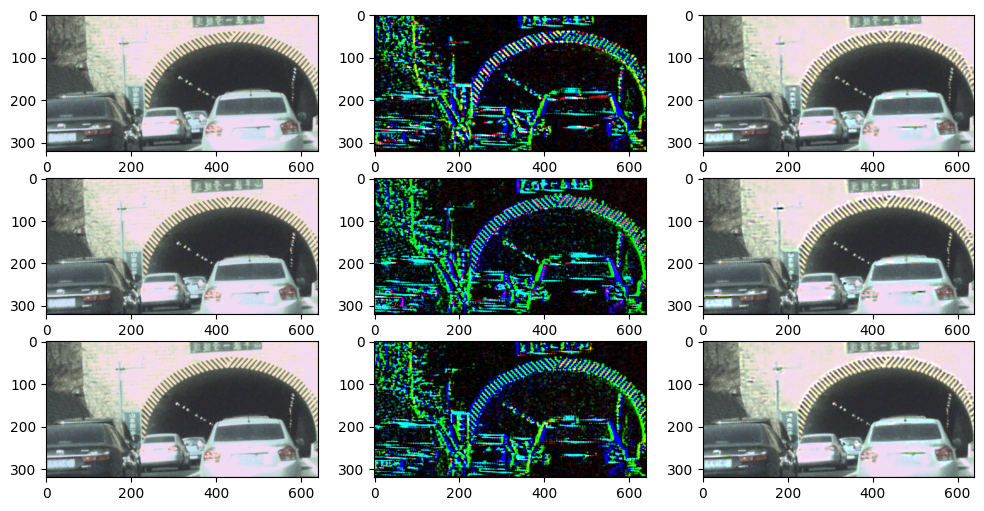

In [3]:
%autoreload
import sys,os
import numpy as np
import torch
import torch.nn.functional as F
import cv2
import math,time
import matplotlib.pyplot as plt

from tianmoucv.isp import fourdirection2xy

aim = 4
N = 3   # read continue N frames

#这两种形式都可以，也可以直接输入string
datapath = [train,val]
datapath = traindata + valdata

for key in key_list:
    dataset = TianmoucDataReader(datapath,N=N,matchkey=key,camera_idx=0)
    img_list = []
    for index in range(aim,min(aim+1,len(dataset))):
        sample = dataset[index]
        tsdiff = torch.Tensor(sample['tsdiff'])
        length = tsdiff.shape[1]
        print('一次性读出N:',N,'个RGB帧以及与其同步的AOP')
        gap = length//(N+1)
        plt.figure(figsize=(12,2*N))  
        for i in range(N):
            F = sample['F'+str(i)]
            F_HDR = sample['F'+str(i)+'_HDR']
            F_HDR[F_HDR>1]=1
            F_HDR[F_HDR<0]=0
            plt.subplot(N,3,1+i*3)
            plt.imshow(F)
            plt.subplot(N,3,2+i*3)
            plt.imshow(tsdiff[:,i*gap,...].permute(1,2,0)*16)
            plt.subplot(N,3,3+i*3)
            plt.imshow(F_HDR)
        plt.show()
    break

# 读取多目数据
- 可以使用系统时间戳对齐
- 注意设置相机序号，从0开始

In [4]:
%autoreload
import sys,os
import numpy as np
import torch
import torch.nn.functional as F
import cv2
import math,time
import matplotlib.pyplot as plt

from tianmoucv.isp import fourdirection2xy

aim = 4
N = 3   # read continue N frames

dataset_top = '/data/yuguo/dataset/checkerboard_20240202'
key='test10'
dataset_0 = TianmoucDataReader(dataset_top,N=N,matchkey=key,camera_idx=0) #index0: rod
dataset_1 = TianmoucDataReader(dataset_top,N=N,matchkey=key,camera_idx=1) #index1: rod_1

#随便读一个sample，把里面的sysTimeStamp拿出来
sample_l = dataset_0[0]
sample_r = dataset_1[0]
ts1 = sample_l['sysTimeStamp']
ts2 = sample_r['sysTimeStamp']
index_bias = (ts2-ts1)/1000.0/33
print(ts1,ts2,'两相机的时间差:',(ts2-ts1)/1000.0,'ms,对应的index 之差为:',index_bias)
#然后怎么处理都行

img_list = []
for index in range(aim,min(aim+1,len(dataset))):
    sample_l = dataset_0[index]
    sample_r = dataset_1[index]
    
    tsdiff = torch.Tensor(sample_l['tsdiff'])
    length = tsdiff.shape[1]
    print('一次性读出N:',N,'个RGB帧以及与其同步的AOP')
    gap = length//(N+1)
    plt.figure(figsize=(12,2*N))  
    for i in range(N):
        F = sample_l['F'+str(i)]
        F_HDR = sample_l['F'+str(i)+'_HDR']
        F_HDR[F_HDR>1]=1
        F_HDR[F_HDR<0]=0
        plt.subplot(N,6,1+i*6)
        plt.imshow(F)
        plt.subplot(N,6,2+i*6)
        plt.imshow(tsdiff[:,i*gap,...].permute(1,2,0)*16)
        plt.subplot(N,6,3+i*6)
        plt.imshow(F_HDR)

    tsdiff = torch.Tensor(sample_r['tsdiff'])
    length = tsdiff.shape[1]
    print('一次性读出N:',N,'个RGB帧以及与其同步的AOP')
    gap = length//(N+1)
    for i in range(N):
        F = sample_r['F'+str(i)]
        F_HDR = sample_r['F'+str(i)+'_HDR']
        F_HDR[F_HDR>1]=1
        F_HDR[F_HDR<0]=0
        plt.subplot(N,6,4+i*6)
        plt.imshow(F)
        plt.subplot(N,6,5+i*6)
        plt.imshow(tsdiff[:,i*gap,...].permute(1,2,0)*16)
        plt.subplot(N,6,6+i*6)
        plt.imshow(F_HDR)
        
    plt.show()


/data/yuguo/dataset/checkerboard_20240202 does not exsist
ERROR: no data found! please check your data path and sample key
/data/yuguo/dataset/checkerboard_20240202 test10
tianmoucData_multiple.py TODO：add overlap parameter
/data/yuguo/dataset/checkerboard_20240202 does not exsist
ERROR: no data found! please check your data path and sample key
/data/yuguo/dataset/checkerboard_20240202 test10
tianmoucData_multiple.py TODO：add overlap parameter


KeyError: None